In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2 as cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

# Load Data

In [23]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [24]:
df = pd.read_csv('../../data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [25]:
def load_data(df):
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        image = np.fromstring(row.pixels, dtype=int, sep=' ')
        scale = image / 255.0
        image_data.append(image)
        image_scaled.append(scale)
        
    return image_data, image_scaled

In [26]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test)
test_target = list(df_test.emotion)

In [66]:
train_data

[array([108,  83,  63, ..., 116, 122, 122]),
 array([137, 142, 159, ..., 191, 192, 192]),
 array([111, 148, 155, ...,  57,  56,  60]),
 array([151, 156, 121, ..., 171,  33,  32]),
 array([248, 187, 149, ..., 195, 200, 194]),
 array([219, 218, 214, ...,  58,  62,  63]),
 array([254, 254, 251, ...,  99, 103, 107]),
 array([105,  96, 100, ..., 174, 191, 168]),
 array([115, 124, 113, ..., 191, 187, 183]),
 array([ 31,  33,  27, ..., 114, 113,  98]),
 array([118, 120, 157, ...,   1,   2,   2]),
 array([206, 202, 202, ..., 189, 231, 228]),
 array([201, 198, 198, ...,   0,   8,   8]),
 array([213, 213, 217, ..., 206, 209, 206]),
 array([224, 233, 243, ..., 255, 254, 254]),
 array([224, 223, 221, ...,  31,  39,  53]),
 array([ 89,  97, 147, ..., 157, 158, 160]),
 array([40, 43, 45, ..., 39, 39, 39]),
 array([ 1,  0,  1, ..., 26, 30, 35]),
 array([254, 254, 254, ..., 148, 137, 146]),
 array([43, 39, 51, ..., 17, 23, 26]),
 array([ 35,  91, 157, ...,   2,   7,   5]),
 array([250, 255, 200, ..., 

In [68]:
train_scaled

[array([0.42352941, 0.3254902 , 0.24705882, ..., 0.45490196, 0.47843137,
        0.47843137]),
 array([0.5372549 , 0.55686275, 0.62352941, ..., 0.74901961, 0.75294118,
        0.75294118]),
 array([0.43529412, 0.58039216, 0.60784314, ..., 0.22352941, 0.21960784,
        0.23529412]),
 array([0.59215686, 0.61176471, 0.4745098 , ..., 0.67058824, 0.12941176,
        0.1254902 ]),
 array([0.97254902, 0.73333333, 0.58431373, ..., 0.76470588, 0.78431373,
        0.76078431]),
 array([0.85882353, 0.85490196, 0.83921569, ..., 0.22745098, 0.24313725,
        0.24705882]),
 array([0.99607843, 0.99607843, 0.98431373, ..., 0.38823529, 0.40392157,
        0.41960784]),
 array([0.41176471, 0.37647059, 0.39215686, ..., 0.68235294, 0.74901961,
        0.65882353]),
 array([0.45098039, 0.48627451, 0.44313725, ..., 0.74901961, 0.73333333,
        0.71764706]),
 array([0.12156863, 0.12941176, 0.10588235, ..., 0.44705882, 0.44313725,
        0.38431373]),
 array([0.4627451 , 0.47058824, 0.61568627, ..., 0

In [57]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

# PCA

## Find how many component is good enough

In [58]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([2.88982571e-01, 1.00608235e-01, 9.39809718e-02, ...,
       5.26681905e-07, 5.20276485e-07, 5.10838653e-07])

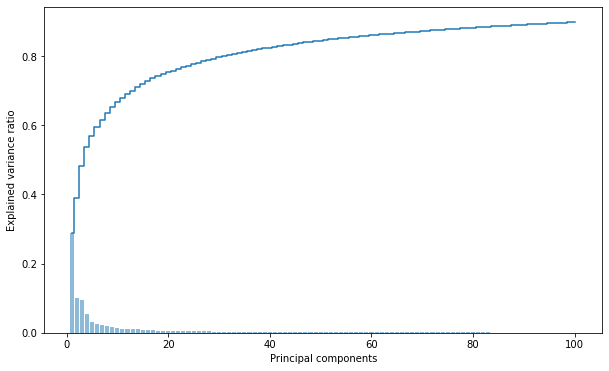

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 101), pca.explained_variance_ratio_[0:100], alpha=0.5, align='center')
plt.step(range(1, 101), np.cumsum(pca.explained_variance_ratio_[0:100]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [30]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
cumsum[104]

0.9012416656118961

In [31]:
cumsum[150]

0.9235147546483438

## EigenFace

In [59]:
pca = PCA(n_components=104, whiten=True)
pca.fit(X_train)

PCA(n_components=104, whiten=True)

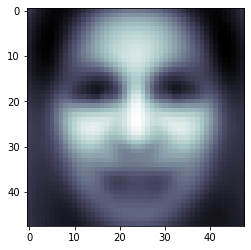

In [60]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [61]:
print(pca.components_.shape)

(104, 2304)


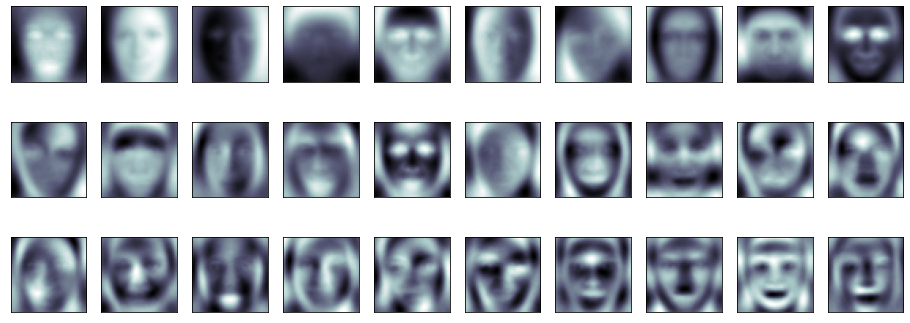

In [62]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

In [63]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(31432, 104)
(7896, 104)


In [64]:
X_train_pca

array([[-0.45897133,  0.96209355, -0.5578826 , ...,  1.14479579,
        -0.09275051, -0.04343307],
       [ 0.49198604, -1.00218016,  0.27409517, ..., -0.58509411,
         0.62847294,  0.03163188],
       [-0.94195011,  1.43852495,  0.29373886, ...,  0.3496943 ,
        -0.24231429,  0.05522309],
       ...,
       [-1.12354735,  0.75749747,  0.34768167, ..., -0.86832148,
        -1.10832286,  0.54998311],
       [ 1.15936041,  0.56849818,  1.0274089 , ..., -0.89151835,
        -0.35489011,  0.86076648],
       [-0.0052239 ,  1.4921513 , -1.59121368, ..., -2.15649225,
         0.19371975, -2.21904863]])

In [37]:
len(X_test)

7896

# PCA (scaled data)

In [71]:
X_train = np.array(train_scaled)
y_train = np.array(train_target)
X_test = np.array(test_scaled)
y_test = np.array(test_target)

In [72]:
X_train

array([[0.42352941, 0.3254902 , 0.24705882, ..., 0.45490196, 0.47843137,
        0.47843137],
       [0.5372549 , 0.55686275, 0.62352941, ..., 0.74901961, 0.75294118,
        0.75294118],
       [0.43529412, 0.58039216, 0.60784314, ..., 0.22352941, 0.21960784,
        0.23529412],
       ...,
       [0.84313725, 0.43921569, 0.40784314, ..., 0.43137255, 0.39215686,
        0.40392157],
       [0.10588235, 0.07843137, 0.07843137, ..., 0.18431373, 0.19215686,
        0.21176471],
       [0.99607843, 0.99607843, 0.98039216, ..., 0.07843137, 0.09803922,
        0.19215686]])

In [73]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([2.88982571e-01, 1.00608235e-01, 9.39809718e-02, ...,
       5.26681905e-07, 5.20276485e-07, 5.10838653e-07])

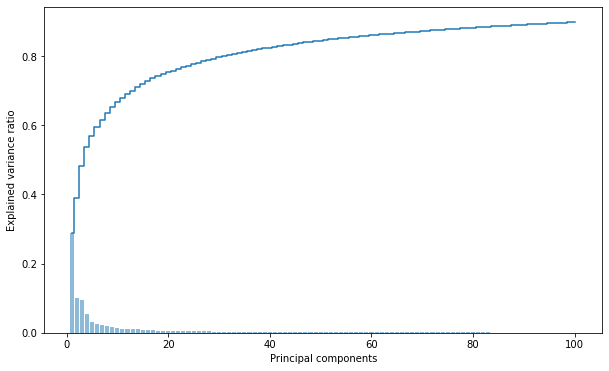

In [74]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 101), pca.explained_variance_ratio_[0:100], alpha=0.5, align='center')
plt.step(range(1, 101), np.cumsum(pca.explained_variance_ratio_[0:100]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [75]:
cumsum = np.cumsum(pca.explained_variance_ratio_[0:500])
cumsum[103]

0.9006065377360861

## EigenFace

In [76]:
pca = PCA(n_components=103, whiten=True)
pca.fit(X_train)

PCA(n_components=103, whiten=True)

In [88]:
pca.mean_.shape

(2304,)

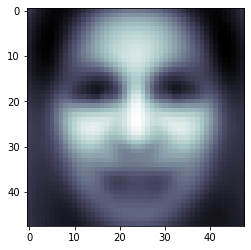

In [86]:
plt.imshow(pca.mean_.reshape((48,48)),
           cmap=plt.cm.bone)

In [78]:
print(pca.components_.shape)

(103, 2304)


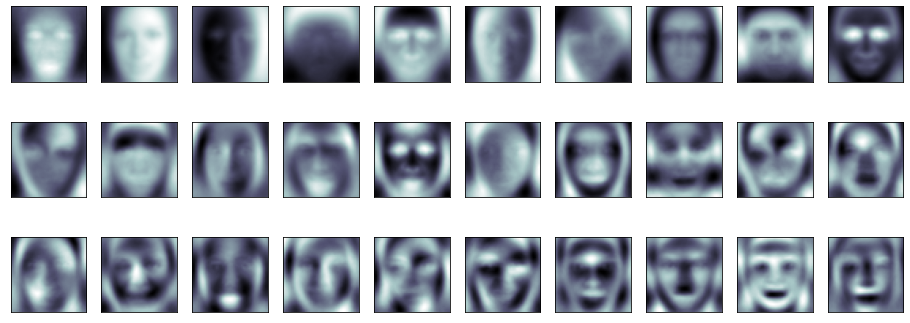

In [79]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((48,48)),
              cmap=plt.cm.bone)

In [82]:
pca.components_

array([[-0.02416829, -0.02379106, -0.02357355, ..., -0.0229494 ,
        -0.02300789, -0.0230159 ],
       [-0.03341106, -0.0345014 , -0.03493637, ..., -0.00774778,
        -0.00911786, -0.00949905],
       [-0.00014501, -0.00074167, -0.00150825, ...,  0.03010625,
         0.02931365,  0.02858946],
       ...,
       [-0.00508268, -0.00635333, -0.00779073, ...,  0.00674207,
         0.00156391, -0.00531122],
       [ 0.04626385,  0.04792862,  0.03432245, ...,  0.02688862,
         0.01057801, -0.00071777],
       [-0.04043629, -0.03187556, -0.00560723, ...,  0.05806188,
         0.0316326 ,  0.01020007]])

In [83]:
pca.components_.shape

(103, 2304)

In [80]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(31432, 103)
(7896, 103)


In [81]:
X_train_pca

array([[-0.45897133,  0.96209355, -0.5578826 , ...,  1.651517  ,
        -0.44245888, -0.44150803],
       [ 0.49198604, -1.00218016,  0.27409517, ..., -0.63976619,
        -0.08084615,  0.9370708 ],
       [-0.94195011,  1.43852495,  0.29373886, ..., -0.57109637,
        -0.83175711, -0.59987794],
       ...,
       [-1.12354735,  0.75749747,  0.34768167, ...,  0.32707915,
        -1.04585252,  1.6399044 ],
       [ 1.15936041,  0.56849818,  1.0274089 , ..., -0.86111444,
        -0.52941709, -0.26025804],
       [-0.0052239 ,  1.4921513 , -1.59121368, ...,  0.67096282,
         1.29145545,  0.31861984]])

# SVM

In [43]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, gamma=0.001)

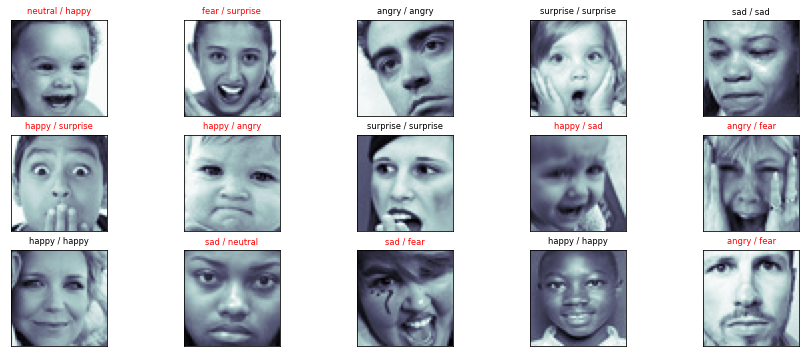

In [53]:
fig = plt.figure(figsize=(15, 6))
for i in range(15):
    rand = random.randint(0, len(X_test))
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[rand].reshape((48,48)),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[rand, np.newaxis])[0]
    color = ('black' if y_pred == y_test[rand] else 'red')
    ax.set_title(emotion_labels[y_pred]+' / '+emotion_labels[y_test[rand]], fontsize='small', color=color)

In [54]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.15      0.21       957
           2       0.32      0.15      0.20      1024
           3       0.47      0.76      0.58      1774
           4       0.35      0.35      0.35      1247
           5       0.60      0.47      0.53       831
           6       0.37      0.41      0.39      1233

    accuracy                           0.42      7066
   macro avg       0.41      0.38      0.38      7066
weighted avg       0.41      0.42      0.39      7066



# Play ground

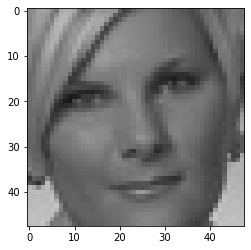

In [89]:
file = '../../data/external/fer2013/train/happy/Training_70433018.jpg'
img = cv.imread(file)
plt.imshow(img)

In [93]:
image = cv.imread(file)    
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray.shape

(48, 48)

In [39]:
pca = PCA(104)
trainsformed = pca.fit_transform(X_train)
inverted = pca.inverse_transform(trainsformed)

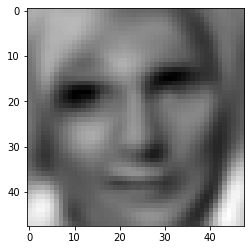

In [44]:
img_compressed = (inverted[1].reshape(48,48))
plt.imshow(img_compressed, cmap='gray')

In [43]:
inverted.shape

(31432, 2304)

In [45]:
trainsformed.shape

(31432, 104)

In [96]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
        
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v', '.', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'pink', 'purple')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [97]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=1)
lr = lr.fit(X_train_pca, y_train)

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_7291/3278092855.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


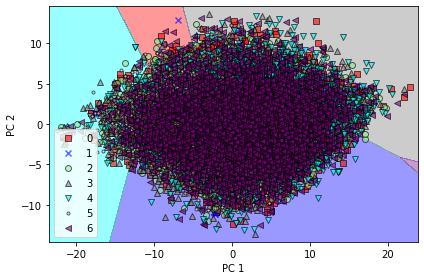

In [98]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

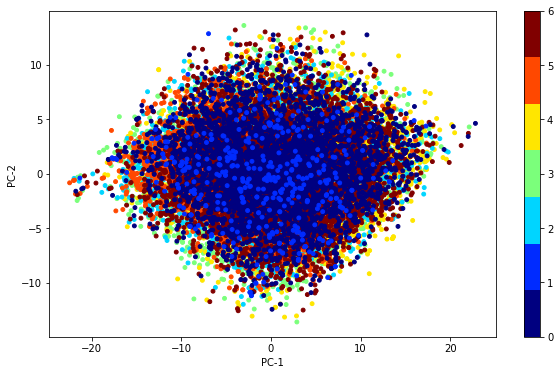

In [102]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 7)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s = 15,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()